From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
epsilons = [0.1]#[0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"#"data/lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [6]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [8]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [16]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.05	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.1	Test Accuracy = 8744 / 10000 = 0.8744
Epsilon: 0.15	Test Accuracy = 7110 / 10000 = 0.711
Epsilon: 0.2	Test Accuracy = 4874 / 10000 = 0.4874
Epsilon: 0.25	Test Accuracy = 2715 / 10000 = 0.2715
Epsilon: 0.3	Test Accuracy = 1418 / 10000 = 0.1418


In [20]:
def fw_step(x_t, epsilon, g_t, x0, fw_stepsize=1):
    # alg from attacks.pdf. Modified to remove momentum.
    g_t_sign = g_t.sign()
    v_t = -epsilon * g_t_sign + x0
    d_t = v_t - x_t
    perturbed_image = x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    #gap_FW = torch.sum(d_t * g_t).item()#torch.dot(d_t, g_t)
    gap_FW = torch.sum(-d_t * g_t).item()
    return perturbed_image, gap_FW

def fw_step_momentum(x_t, epsilon, g_t, m_t_last, x0, momentum = 0.2,fw_stepsize = 1):
    # alg from attacks.pdf
    m_t = (1 - momentum)*g_t
    if m_t_last is not None:
        m_t += momentum*m_t_last
    m_t_sign = m_t.sign()
    v_t = -epsilon * m_t_sign + x0
    d_t = v_t - x_t
    perturbed_image = x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, m_t

def fw_step_momentum1(x_t, epsilon, g_t, m_t_last, x0, momentum = 0.2,fw_stepsize = 1):
    # alg from attacks.pdf
    m_t = (1 - momentum)*g_t
    if m_t_last is not None:
        m_t += momentum*m_t_last
    m_t_sign = m_t.sign()
    v_t = -epsilon * m_t_sign + x0
    d_t = v_t - x_t
    perturbed_image = x_t - momentum * epsilon * m_t_sign - momentum * (x_t - x0)#x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, m_t


def fw_step_pairwise():
    # alg from FW_varients.pdf
    return

In [37]:
def away_oracle():
    return
def fw_step_away(x_t, epsilon, g_t, x0, S_t):
    info = {}
    # alg from FW_varients.pdf
    # FW direction
    g_t_sign = g_t.sign()
    s_t = -epsilon * g_t_sign + x0
    d_t_FW = s_t - x_t
    # AWAY direction. From set of vertices already visited
    away_costs = []
    for v in S_t:
        away_costs.append(torch.sum(g_t*v).item())
    v_t_idx = np.argmax(away_costs)
    v_t = S_t[v_t_idx]
    # at each iter x_t expressed by convex combination of active verticies
    #alpha_v_t = alphas_t[v_t_idx]
    d_t_AWAY = x_t - v_t
    #check optimality (FW gap)
    gap_FW = torch.sum(-g_t * d_t_FW).item()
    gap_AWAY = torch.sum(-g_t*d_t_AWAY).item()
    info['gap_FW'] = gap_FW
    info['gap_AS'] = gap_AWAY

    
    # check which direction is closer to the gradient
    if gap_FW >= gap_AWAY:
        info['step'] = 'FW'
        info['S_idx'] = -1 #idicate last vertex is S_t is used which is the current FW direction
        d_t = d_t_FW
        max_step = 1
        S_t.append(d_t.clone().detach())
    else:
        info['step'] = 'AS'
        info['S_idx'] = v_t_idx
        d_t = d_t_AWAY
        alpha_v_t = 0.1 # REMOVE ME or implement line searching or solve system to get alpha coeffs
        max_step = 0.1 #alpha_v_t / (1 - alpha_v_t) # this is a safe step size to remain in C. Need to verify this

    # line-search for the best gamma (FW stepsize)
    perturbed_image = x_t + max_step * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, S_t, info


In [13]:
class AdversarialLoss(nn.Module):
    def __init__(self, num_classes, specific_label=None):
        """
        Initialize the AdversarialLoss.
        
        Args:
        - num_classes (int): Total number of classes in the classification problem.
        - specific_label (int, optional): A specific incorrect label to target. If None, the loss will consider all incorrect labels.
        """
        super(AdversarialLoss, self).__init__()
        self.num_classes = num_classes
        self.specific_label = specific_label

    def forward(self, outputs, targets):
        """
        Compute the adversarial loss.
        
        Args:
        - outputs (torch.Tensor): The model outputs (logits) of shape (batch_size, num_classes).
        - targets (torch.Tensor): The true labels of shape (batch_size,).
        
        Returns:
        - loss (torch.Tensor): The computed adversarial loss.
        """
        batch_size = outputs.size(0)
        if self.specific_label is not None:
            # Targeting a specific incorrect label
            incorrect_labels = torch.full_like(targets, self.specific_label)
            mask = (incorrect_labels != targets).float()
            specific_log_probs = F.log_softmax(outputs, dim=1).gather(1, incorrect_labels.unsqueeze(1)).squeeze(1)
            loss = -specific_log_probs * mask
            return loss.mean()
        else:
            # Averaging over all incorrect labels
            log_probs = F.log_softmax(outputs, dim=1)
            incorrect_log_probs = log_probs.clone()
            correct_log_probs = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)
            for i in range(batch_size):
                incorrect_log_probs[i, targets[i]] = float('-inf')
            average_incorrect_log_probs = incorrect_log_probs.logsumexp(dim=1) - torch.log(torch.tensor(self.num_classes - 1, dtype=torch.float))
            loss = -average_incorrect_log_probs
            return loss.mean()

In [61]:
def test_fw( model, device, test_loader, epsilon,num_fw_iter, num_test = 1000, method='fw', early_stopping = None):

    # Accuracy counter
    correct = 0
    adv_examples = []
    hist = []
    ex_num = 0
    # Loop over all examples in test set
    for x0, target in test_loader:

        x_t = x0.detach().clone().to(device)  # Clone and move to device
        # Send the data and label to the device
        x0, target = x0.to(device), target.to(device)
        x0_denorm = denorm(x0)
        #x_t.requires_grad = True  #Set requires_grad attribute of tensor. Important for Attack
        m_t_last = None # gradient from previous iter
        had_first_success = False
        gap_FW = None
        S_t = [x0_denorm]
        info = None

        for t in range(num_fw_iter):
            x_t.requires_grad = True
            # Forward pass the data through the model
            output = model(x_t)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # If the initial prediction is wrong, don't bother attacking, just move on
            if (init_pred.item() != target.item()) and (t == 0):
                break

            # Calculate the loss
            criterion = AdversarialLoss(10)
            loss = criterion(output, target)
            #1 - F.nll_loss(output, target) # DNN maximizing POSITIVE log liklihood
            #criterion = nn.CrossEntropyLoss()
            #loss = criterion(output, target)
            #loss = untargeted_attack_loss(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect ``datagrad``
            x_t_grad = x_t.grad#.data

            # Restore the data to its original scale
            x_t_denorm = denorm(x_t)

            # Call Attack
            if method == 'fgsm':
                perturbed_image = fgsm_attack(x_t_denorm, epsilon, x_t_grad)
            elif method == 'fw':
                perturbed_image, gap_FW = fw_step(x_t_denorm, epsilon, x_t_grad, x0_denorm)
            elif method == 'fw_AWAY':
                perturbed_image, S_t, info = fw_step_away(x_t_denorm, epsilon, x_t_grad, x0_denorm, S_t)
            elif method == 'fw_momentum':
                perturbed_image, m_t_last = fw_step_momentum(x_t_denorm, epsilon, x_t_grad, m_t_last, x0_denorm)
            # Reapply normalization
            x_t = transforms.Normalize((0.1307,), (0.3081,))(perturbed_image).detach()

            # Re-classify the perturbed image
            x_t.requires_grad = False
            output = model(x_t)

            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == target.item():
                success = False
                first_success = False
                if t == num_fw_iter - 1:
                    correct += 1
                # Special case for saving 0 epsilon examples
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) ) 
            else:
                first_success =  not had_first_success
                had_first_success = True
                success = True
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                #break # early stopping if attack sucessful, paper doesn't use this so I wont.
            hist_iter = {
                'example_idx':ex_num,
                'FW_iter': t + 1, # original example is 0
                'gap_FW': gap_FW if gap_FW is not None else None,
                'success': success,
                'first_success': first_success
            }
            if info is not None:
                hist_iter.update(info) # some methods output dict containing info at each step
            hist.append(hist_iter)
            if (early_stopping == 'pred') and first_success:
                break

        ex_num += 1
        if ex_num >= num_test:
            break

    # Calculate final accuracy for this epsilon
    final_acc = correct/num_test
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {num_test} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, pd.DataFrame(hist)

In [62]:
accuracies = []
examples = []
fw_iters = [10]
eps = 0.15# * (0.4242129623889923 + 2.821486711502075)
adv_examples = []
fw_stepsize = 0.5
hist = None
# Run test for each epsilon
#for eps in epsilons:
for num_fw_iter in fw_iters:
    acc, ex, hist = test_fw(model, device, test_loader, eps, num_fw_iter, method='fw_AWAY', early_stopping='pred')
    accuracies.append(acc)
    examples.append(ex)
hist

Epsilon: 0.15	Test Accuracy = 338 / 1000 = 0.338


,example_idx,FW_iter,gap_FW,success,first_success,gap_AS,step,S_idx
0,0,1,11.422285,False,False,0.000000,FW,-1
1,0,2,5.184308,False,False,2.682561,FW,-1
2,0,3,7.767963,False,False,4.822862,FW,-1
3,0,4,5.886448,False,False,3.910175,FW,-1
4,0,5,8.458188,False,False,5.014561,FW,-1
...,...,...,...,...,...,...,...,...
5238,998,2,2.219562,False,False,1.605941,FW,-1
5239,998,3,6.280021,False,False,3.712521,FW,-1
5240,998,4,3.402049,True,True,2.546825,FW,-1
5241,999,1,12.196990,False,False,0.000000,FW,-1


In [57]:
hist['S_idx'].unique()

array([-1,  0], dtype=int64)

In [58]:
hist.groupby('step').count()

,example_idx,FW_iter,FW_gap,success,first_success,gap_FW,gap_AS,S_idx
step,,,,,,,,
AS,56,56,0,56,56,56,56,56
FW,5182,5182,0,5182,5182,5182,5182,5182


In [42]:
# accuracy
hist.groupby('example_idx')['first_success'].sum().mean()

0.9838709677419355

In [46]:
# average number of iterations for success
hist[hist['first_success']]['FW_iter'].mean()

2.067622950819672

<Axes: xlabel='FW_iter'>

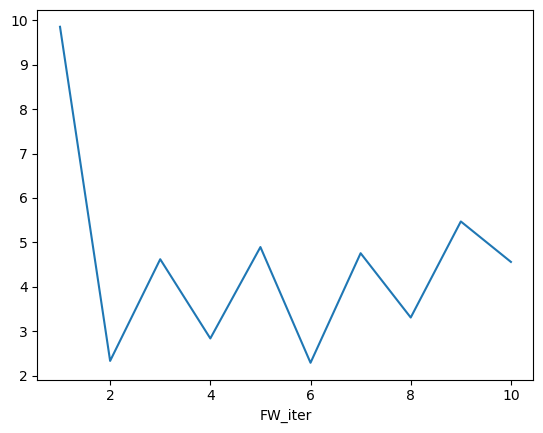

In [60]:
hist[hist['first_success']].groupby('FW_iter')['gap_FW'].mean().plot()

<Axes: xlabel='FW_iter'>

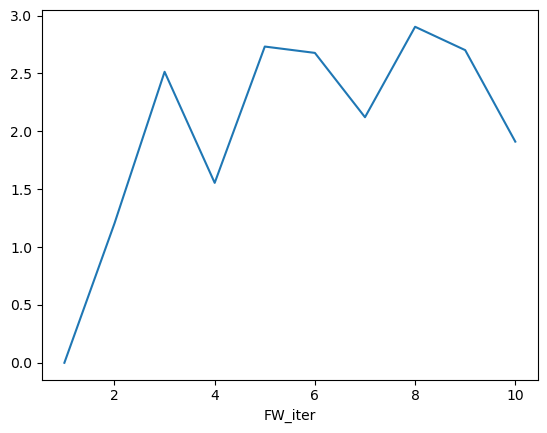

In [65]:
hist[hist['first_success']].groupby('FW_iter')['gap_AS'].mean().plot()

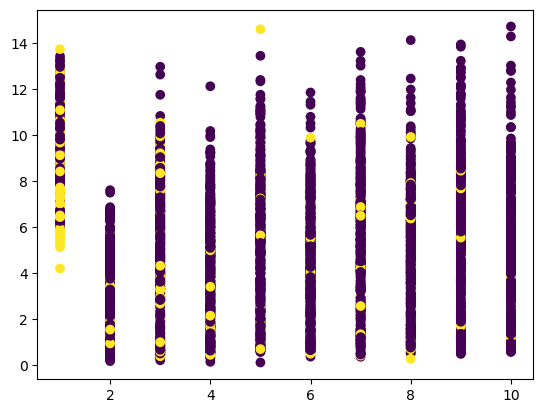

In [66]:
plt.scatter(hist['FW_iter'],hist['gap_FW'], c=hist['success'])

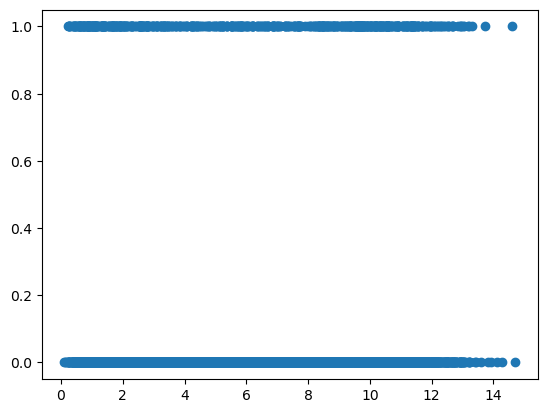

In [68]:
plt.scatter(hist['gap_FW'], hist['success'])

In [17]:
hist['gap_trans'] = np.exp(-hist['FW_gap'])

In [93]:
hist.groupby('success')['FW_gap'].mean()

success
False    7.912504
True     9.346062
Name: FW_gap, dtype: float64

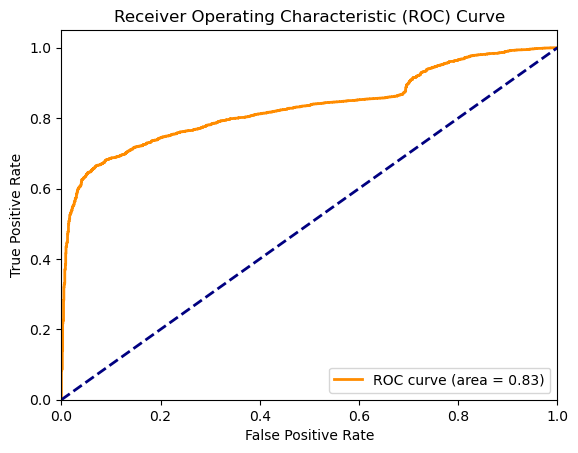

In [23]:
from sklearn.metrics import roc_curve, auc

# Sample data: true binary labels and predicted probabilities
y_true = hist['success']
y_scores = 1- hist['gap_trans']

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

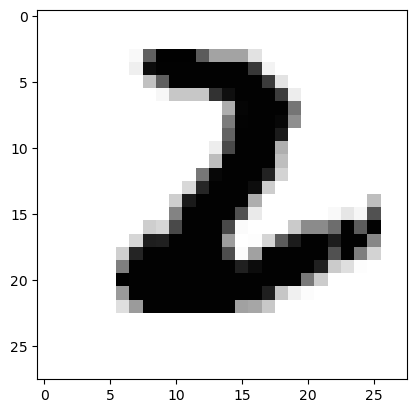

In [54]:
plt.imshow(ex[1][2], cmap='gray')

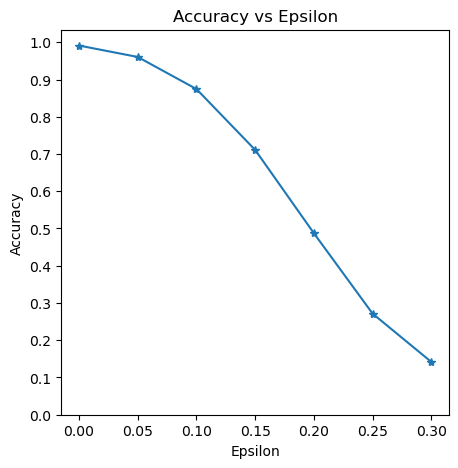

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

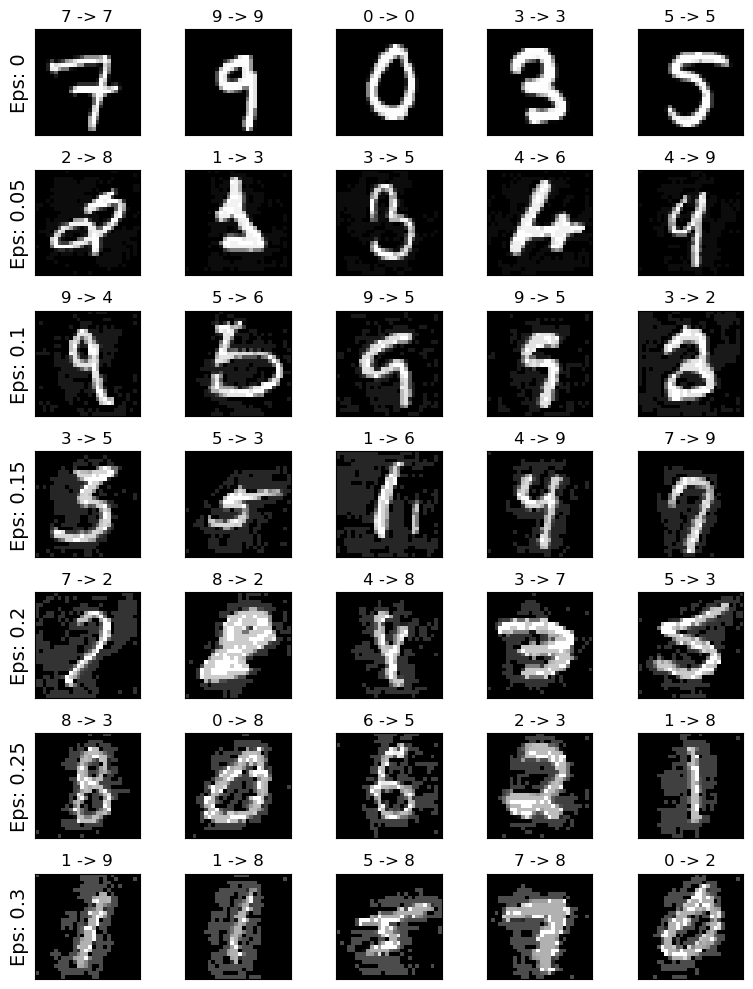

In [18]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()